In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import optuna

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train_extra = pd.read_csv('data/training_extra.csv')
sample = pd.read_csv('data/sample_submission.csv')

# сохраняю id
test_id = test['id']

In [3]:
train

,id,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312
...,...,...,...,...,...,...,...,...,...,...,...
299995,299995,Adidas,Leather,Small,9.0,No,No,Tote,Blue,12.730812,129.99749
299996,299996,Jansport,Leather,Large,6.0,No,Yes,Tote,Blue,26.633182,19.85819
299997,299997,Puma,Canvas,Large,9.0,Yes,Yes,Backpack,Pink,11.898250,111.41364
299998,299998,Adidas,Nylon,Small,1.0,No,Yes,Tote,Pink,6.175738,115.89080


# Валидация данных

### Признаки: 'Brand', 'Material', 'Size', 'Style', 'Color'
- Категориальные с равномерным распределением
- Делаю новые признаки по категориям (Nan значение отдельный признак)
- drop_first=True -
- drop_first=False - 

### Признаки: 'Laptop Compartment', 'Waterproof'
- Категориальные, бинарные с равномерным распределением
- Делаю новые признаки по категориям (Nan значение отдельный признак) drop_first=True

### Признак 'Weight Capacity (kg)'
- в train nan удаляю строки
- в test заменяю на среднее значение

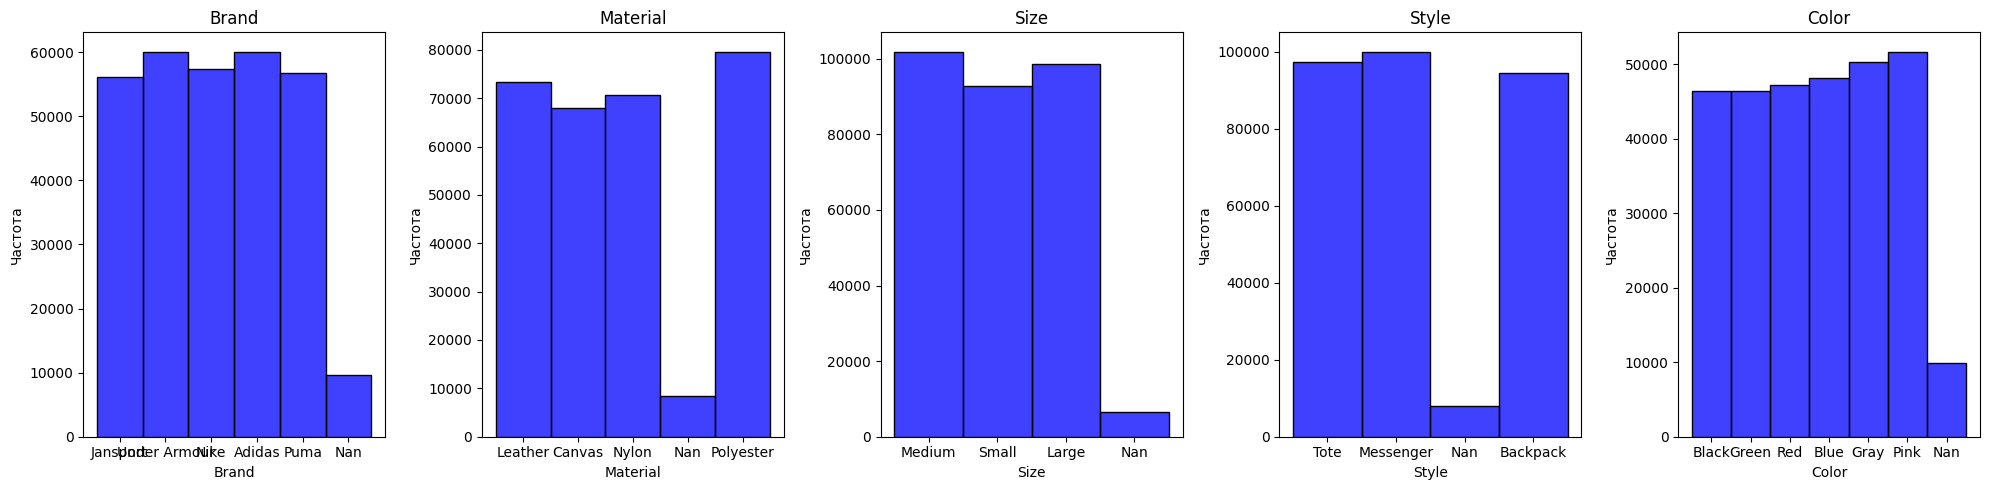

In [4]:
columns_to_plot = ['Brand', 'Material', 'Size', 'Style', 'Color']

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

for i, column in enumerate(columns_to_plot):
    sns.histplot(train[column].fillna('Nan'), bins=20, color='blue', ax=axes[i], discrete=True)
    axes[i].set_title(column)
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

In [5]:
train = pd.get_dummies(train, columns=columns_to_plot, dtype='int', dummy_na=True, drop_first=False)
test = pd.get_dummies(test, columns=columns_to_plot, dtype='int', dummy_na=True, drop_first=False)

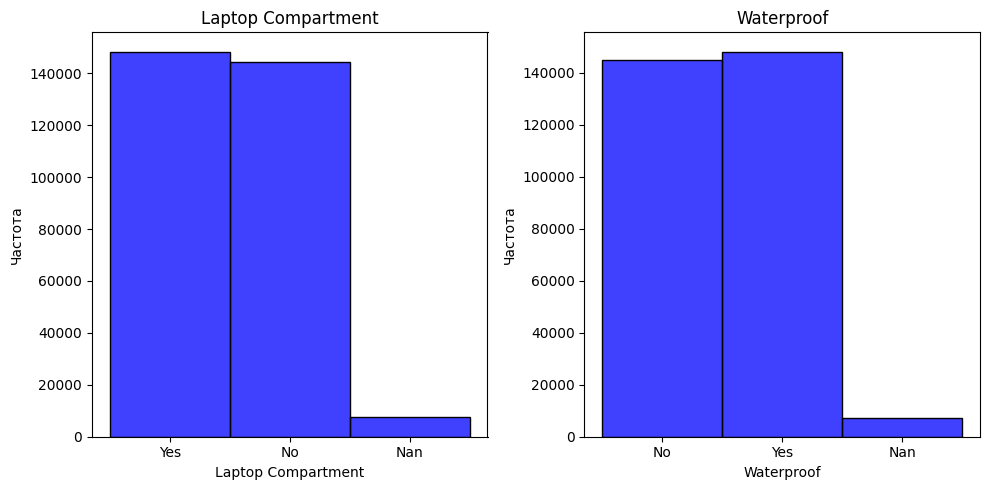

In [6]:
columns_to_plot = ['Laptop Compartment', 'Waterproof']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for i, column in enumerate(columns_to_plot):
    sns.histplot(train[column].fillna('Nan'), bins=20, color='blue', ax=axes[i], discrete=True)
    axes[i].set_title(column)
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

In [7]:
train = pd.get_dummies(train, columns=columns_to_plot, dtype='int', dummy_na=True, drop_first=True)
test = pd.get_dummies(test, columns=columns_to_plot, dtype='int', dummy_na=True, drop_first=True)

In [8]:
train = train.dropna(subset=['Weight Capacity (kg)'])
test['Weight Capacity (kg)'] = test['Weight Capacity (kg)'].fillna(test['Weight Capacity (kg)'].mean())

In [9]:
train.drop(columns='id', inplace=True)
test.drop(columns='id', inplace=True)

In [10]:
X = train.drop(columns='Price')
y = train['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [11]:
params = {'random_seed': 42,
          'verbose': 0,
          'eval_metric': 'RMSE',
          }

In [12]:
cat_model = CatBoostRegressor(**params)
cat_model.fit(X_train, y_train)

pred = cat_model.predict(X_test)
rmse = root_mean_squared_error(y_test, pred)
rmse

39.084169169827966

In [13]:
pred = cat_model.predict(test)

In [14]:
output = pd.DataFrame({'id': test_id, 'Price': pred})
output.to_csv('data/cat_model.csv', index=False)

In [ ]:
# 39.22710